## Import Modules

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import load_img
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D

## Load the Dataset

In [2]:
# DATASET = 'affectnet'
# DATASET = 'fer2013'
# DATASET = 'mma'
DATASET = 'merged_dataset'

TRAIN_DIR = f"input/{DATASET}/train/"
TEST_DIR = f"input/{DATASET}/test/"
VALID_DIR = f"input/{DATASET}/valid/"

In [3]:
def load_dataset(directory):
    image_paths = []
    labels = []

    for label in os.listdir(directory):
        for filename in os.listdir(directory+label):
            image_path = os.path.join(directory, label, filename)
            image_paths.append(image_path)
            labels.append(label)

        # print(label, "Completed")

    return image_paths, labels

In [4]:
train = pd.DataFrame()
train['image'], train['label'] = load_dataset(TRAIN_DIR)
train = train.sample(frac=1).reset_index(drop=True) # shuffle

train.head()

,image,label
0,input/merged_dataset/train/neutral\22186Exp6fi...,neutral
1,input/merged_dataset/train/neutral\85777Exp6as...,neutral
2,input/merged_dataset/train/neutral\41708Exp6di...,neutral
3,input/merged_dataset/train/happy\53065Exp3amaz...,happy
4,input/merged_dataset/train/angry\Angry.32873.jpg,angry


In [5]:
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(TEST_DIR)
test = test.sample(frac=1).reset_index(drop=True)

test.head()

,image,label
0,input/merged_dataset/test/happy\61304Exp3astou...,happy
1,input/merged_dataset/test/fear\Training_963292...,fear
2,input/merged_dataset/test/surprise\Training_39...,surprise
3,input/merged_dataset/test/angry\image0021542.jpg,angry
4,input/merged_dataset/test/surprise\image002089...,surprise


In [6]:
valid = pd.DataFrame()
valid['image'], valid['label'] = load_dataset(VALID_DIR)
valid = valid.sample(frac=1).reset_index(drop=True)

valid.head()

,image,label
0,input/merged_dataset/valid/neutral\Training_88...,neutral
1,input/merged_dataset/valid/neutral\Neutral.237...,neutral
2,input/merged_dataset/valid/happy\ffhq_2463.png,happy
3,input/merged_dataset/valid/disgust\25025Exp1ho...,disgust
4,input/merged_dataset/valid/neutral\ffhq_4104.png,neutral


## Exploratory Data Analysis

<Axes: xlabel='count', ylabel='label'>

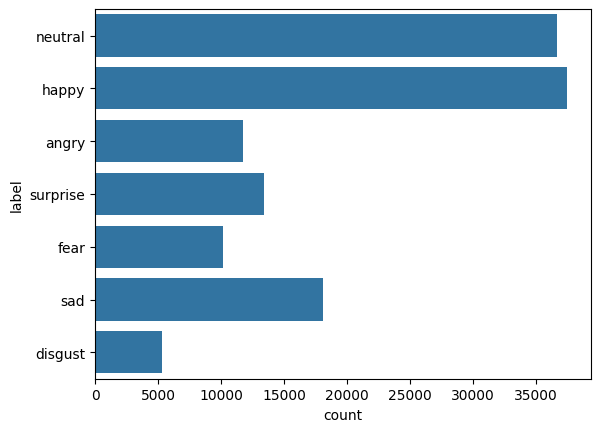

In [7]:
sns.countplot(train['label'])

## Grid of dataset images

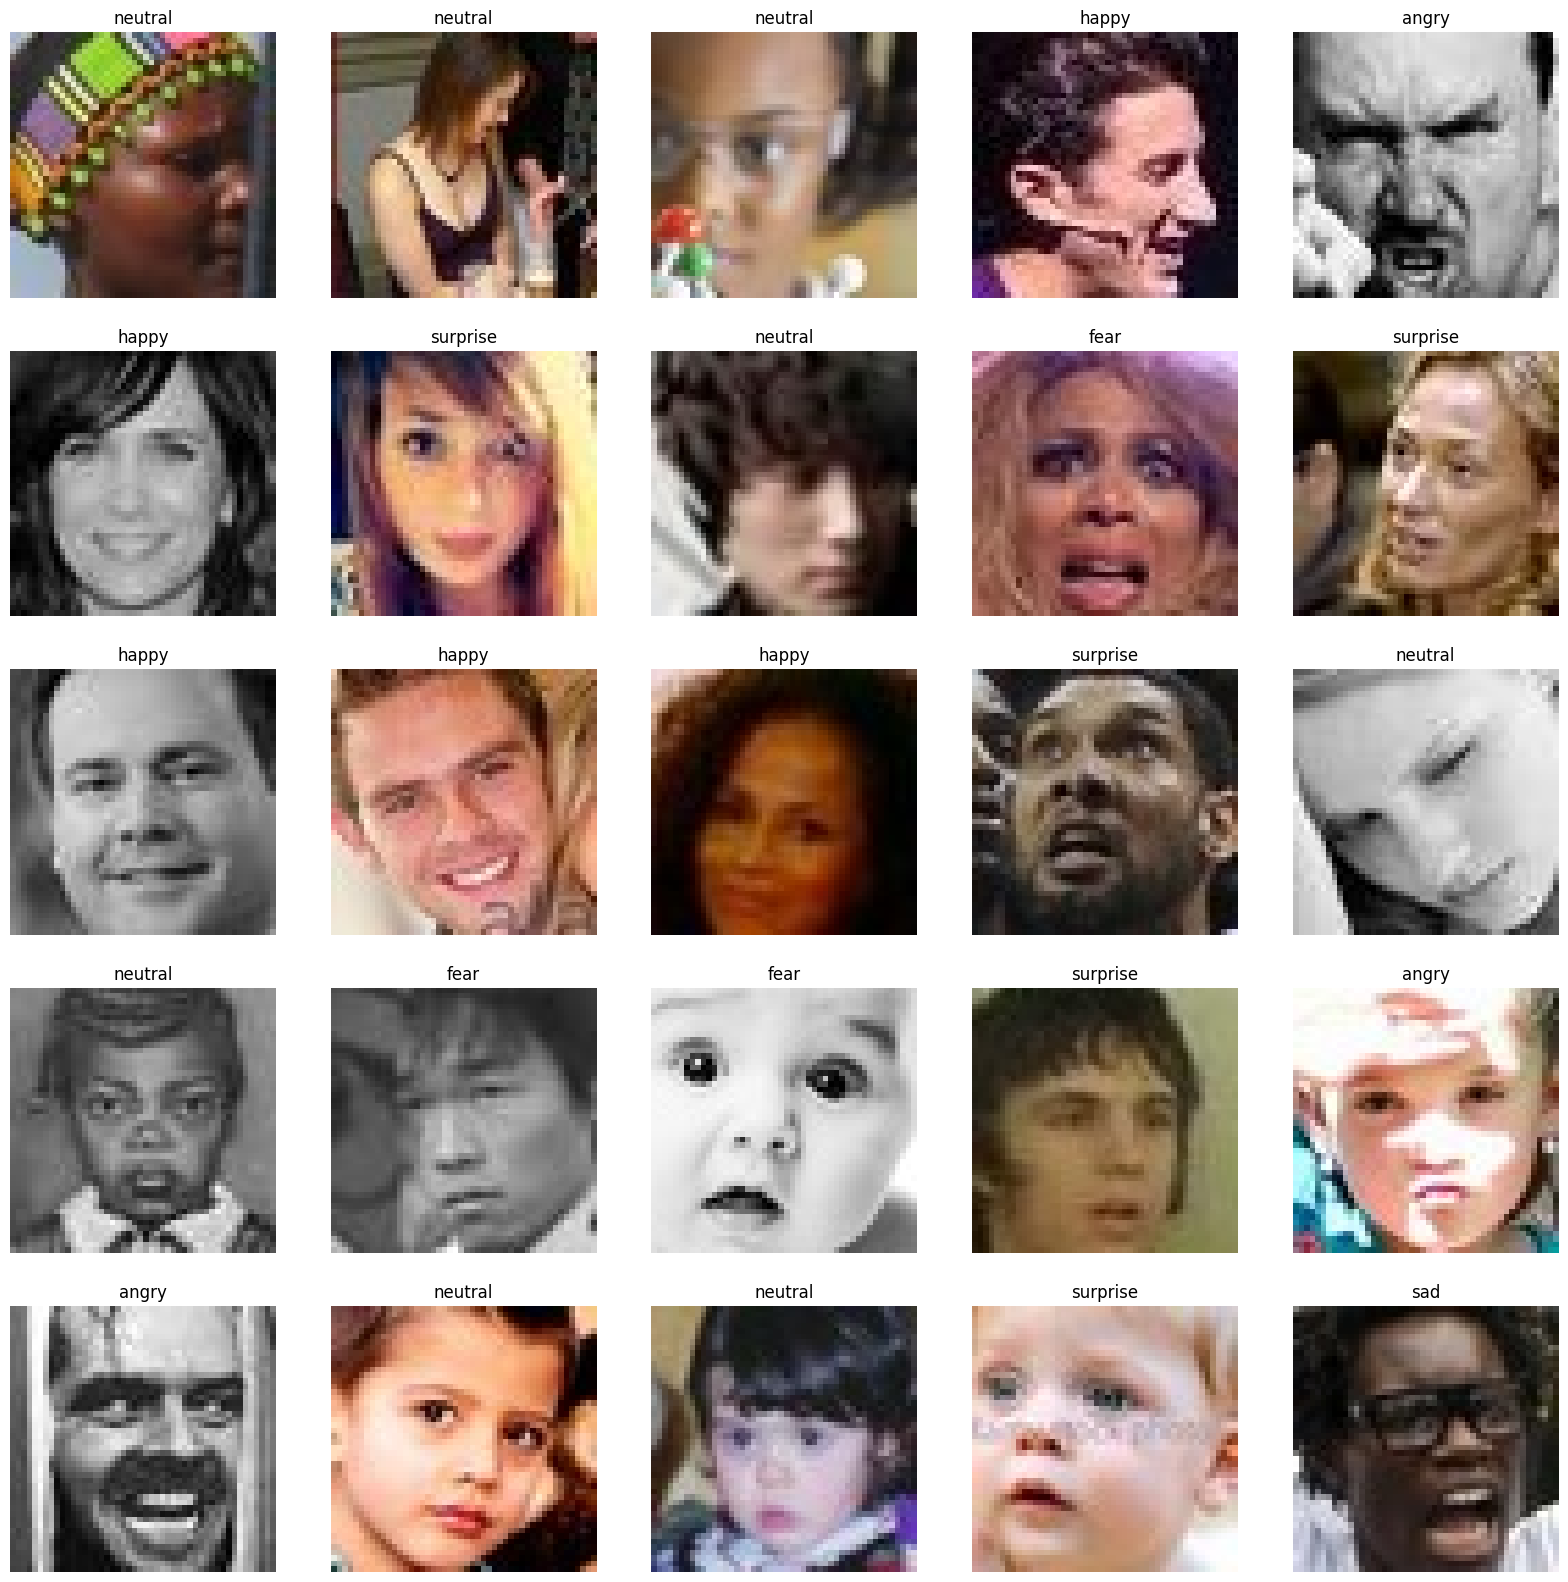

In [8]:
plt.figure(figsize=(20,20))
files = train.iloc[0:25]

for index, image_path, label in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(image_path)
    img = np.array(img)
    
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

## Feature Extraction

In [9]:
def extract_features(images):
    features = []
    for image_path in tqdm(images):
        img = load_img(image_path, color_mode='grayscale')
        img = np.array(img)
        
        if DATASET == 'affectnet': # affectnet images are 96x96
            img = img[::2, ::2] # so downsampling to 48x48 is required
        
        features.append(img)
    
    features = np.array(features)
    features = features.reshape(len(features), 48, 48, 1)
    
    return features

In [10]:
train_features = extract_features(train['image'])
x_train = train_features / 255.0

  0%|          | 0/132806 [00:00<?, ?it/s]

In [11]:
test_features = extract_features(test['image'])
x_test = test_features / 255.0

  0%|          | 0/18973 [00:00<?, ?it/s]

In [12]:
valid_features = extract_features(valid['image'])
x_valid = valid_features / 255.0

  0%|          | 0/37959 [00:00<?, ?it/s]

In [13]:
labels = train['label'].unique()
print(labels)

['neutral' 'happy' 'angry' 'surprise' 'fear' 'sad' 'disgust']


In [14]:
## convert label to integer
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(labels)

y_train = le.transform(train['label'])
y_train = to_categorical(y_train, num_classes=len(labels))

y_test = le.transform(test['label'])
y_test = to_categorical(y_test, num_classes=len(labels))

y_valid = le.transform(valid['label'])
y_valid = to_categorical(y_valid, num_classes=len(labels))

In [15]:
y_train[0]

array([0., 0., 0., 0., 1., 0., 0.])

In [16]:
input_shape = (48, 48, 1)
output_class = len(labels)

## Model Creation

In [17]:
# 5 layer model
model = Sequential(name='5-layer')

# convolutional layers
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', input_shape=input_shape, padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(1024, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.25))

model.add(Conv2D(1024, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# fatten layer
model.add(Flatten())

# fully connected layers
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# output layer
model.add(Dense(output_class, activation='softmax'))

# _______________________________________________________

# # 6 layer model
# model = Sequential(name='6-layer')

# # Convolutional layers
# model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', input_shape=input_shape, padding='same'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
# model.add(Dropout(0.25))

# model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D((2, 2), padding='same'))
# model.add(Dropout(0.25))

# model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
# model.add(Dropout(0.25))

# model.add(Conv2D(1024, kernel_size=(3, 3), activation='relu', padding='same'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
# model.add(Dropout(0.25))

# model.add(Conv2D(1024, kernel_size=(3, 3), activation='relu', padding='same'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
# model.add(Dropout(0.25))

# model.add(Conv2D(2048, kernel_size=(3, 3), activation='relu', padding='same'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
# model.add(Dropout(0.25))

# # global average pooling layer
# model.add(GlobalAveragePooling2D())

# # fully connected layers
# model.add(Dense(output_class, activation='softmax'))

In [18]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "5-layer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 48, 48, 128)         │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 48, 48, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 24, 24, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 12, 12, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 6, 6, 1024)          │       4,719,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 6, 6, 1024)          │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 3, 3, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 3, 3, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 3, 3, 1024)          │       9,438,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 3, 3, 1024)          │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 1, 1, 1024)          │              

 Total params: 16,307,207 (62.21 MB)

 Trainable params: 16,299,783 (62.18 MB)

 Non-trainable params: 7,424 (29.00 KB)

## Train the model

In [19]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=32,
    epochs=100,
    validation_data=(x_valid, y_valid)
)

Epoch 1/100
4151/4151 ━━━━━━━━━━━━━━━━━━━━ 1574s 378ms/step - accuracy: 0.3226 - loss: 1.8942 - val_accuracy: 0.5415 - val_loss: 1.2655
Epoch 2/100
4151/4151 ━━━━━━━━━━━━━━━━━━━━ 1567s 377ms/step - accuracy: 0.5424 - loss: 1.2571 - val_accuracy: 0.5436 - val_loss: 1.4947
Epoch 3/100
4151/4151 ━━━━━━━━━━━━━━━━━━━━ 1552s 374ms/step - accuracy: 0.5849 - loss: 1.1477 - val_accuracy: 0.6070 - val_loss: 1.0802
Epoch 4/100
4151/4151 ━━━━━━━━━━━━━━━━━━━━ 1554s 374ms/step - accuracy: 0.6142 - loss: 1.0701 - val_accuracy: 0.6353 - val_loss: 1.0093
Epoch 5/100
4151/4151 ━━━━━━━━━━━━━━━━━━━━ 1540s 371ms/step - accuracy: 0.6470 - loss: 0.9894 - val_accuracy: 0.6460 - val_loss: 0.9852
Epoch 6/100
4151/4151 ━━━━━━━━━━━━━━━━━━━━ 1528s 368ms/step - accuracy: 0.6811 - loss: 0.9070 - val_accuracy: 0.6534 - val_loss: 0.9841
Epoch 7/100
4151/4151 ━━━━━━━━━━━━━━━━━━━━ 1520s 366ms/step - accuracy: 0.7071 - loss: 0.8313 - val_accuracy: 0.6777 - val_loss: 0.9260
Epoch 8/100
4151/4151 ━━━━━━━━━━━━━━━━━━━━ 1525s

## Save the model

In [20]:
model.save(f'models/{model.name}_{DATASET}.keras')

## Plot the Results

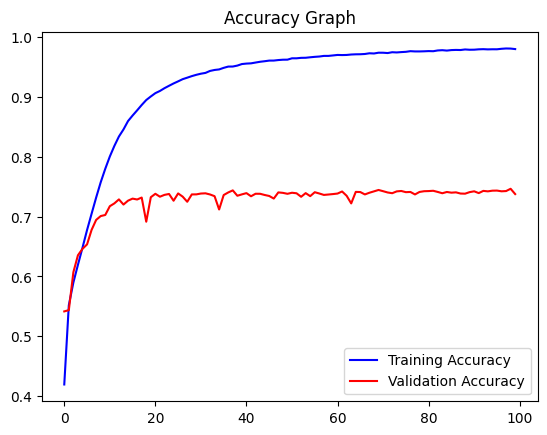

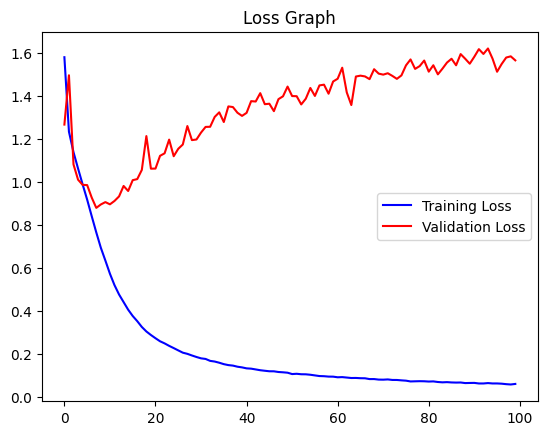

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()

plt.show()

## Accuracy, F1, Precision, Recall

In [22]:
from tensorflow.keras.models import load_model

# model = load_model('models/model.keras')

# Przewidywanie klas na zestawie testowym
y_pred_prob = model.predict(x_test)

593/593 ━━━━━━━━━━━━━━━━━━━━ 47s 78ms/step


In [23]:
y_pred = np.array([np.eye(len(row))[row.argmax()] for row in y_pred_prob])

In [24]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred, target_names=labels)
print(report)

              precision    recall  f1-score   support

     neutral       0.75      0.65      0.69      1680
       happy       0.55      0.28      0.37       757
       angry       0.77      0.67      0.72      1450
    surprise       0.85      0.85      0.85      5356
        fear       0.68      0.83      0.75      5240
         sad       0.67      0.61      0.64      2580
     disgust       0.72      0.67      0.69      1910

   micro avg       0.74      0.74      0.74     18973
   macro avg       0.71      0.65      0.67     18973
weighted avg       0.74      0.74      0.74     18973
 samples avg       0.74      0.74      0.74     18973



In [25]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(y_test, y_pred)
print(acc)

0.7405260106467085


## Confusion matrix

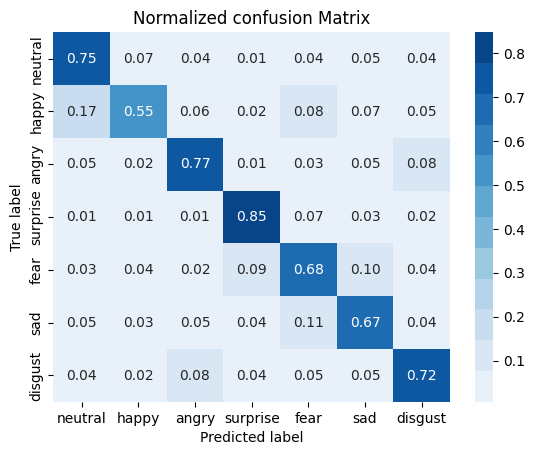

In [26]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(
    le.inverse_transform(np.argmax(y_test, axis=1)),
    le.inverse_transform(np.argmax(y_pred, axis=1)),
    normalize='true'
)

sns.heatmap(
    cm,
    annot=True,
    xticklabels=labels,
    yticklabels=labels,
    cmap=sns.color_palette('Blues', 12),
    fmt='.2f'
)
plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.title('Normalized confusion Matrix')
plt.show()

## Test with Image Data

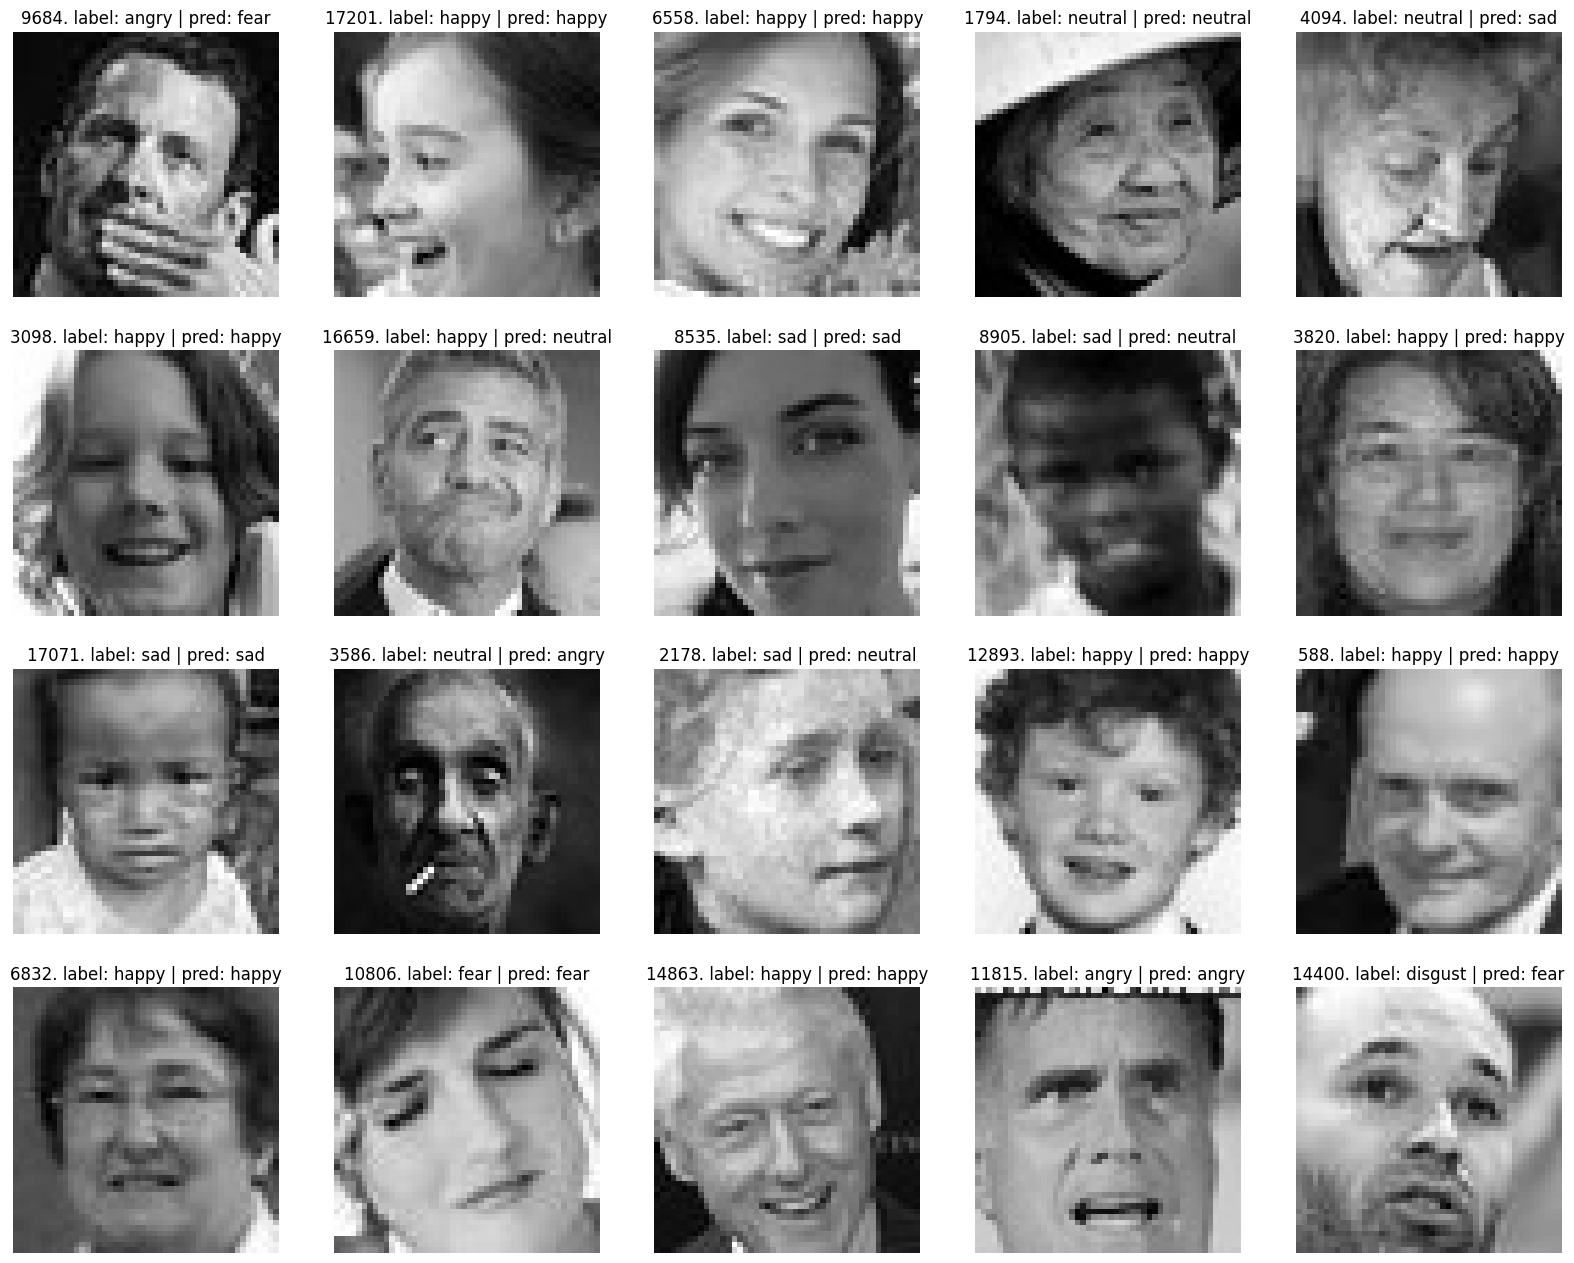

In [27]:
plt.figure(figsize=(20,20))

for i in range(20):
    plt.subplot(5, 5, i+1)

    img_index = random.randint(0, len(test))
    img = x_test[img_index]
    
    label = test['label'][img_index]

    pred = model.predict(img.reshape(1, 48, 48, 1), verbose=0)
    pred_label = le.inverse_transform([pred.argmax()])[0]
    
    plt.title(f"{img_index}. label: {label} | pred: {pred_label}")
    plt.imshow(img.reshape(48, 48), cmap='gray')
    plt.axis('off')